In [1]:
import sys
sys.path.append('./py/')

In [2]:
import ee
import wxee
import geopandas as gpd
import numpy as np
import semantique as sq
import json
import time
from config import *
from dynamic_product import Product
from shapely.geometry import shape
from semantique.dimensions import TIME, SPACE, X, Y
import rasterio
import copy

/opt/anaconda3/envs/semantique/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
credentials = ee.ServiceAccountCredentials(service_account, ee_key)
tz="UTC"
ee.Initialize(
    credentials,
    opt_url='https://earthengine-highvolume.googleapis.com'
)

In [4]:
def lookup(layout, *reference):
    obj = layout
    for key in reference:
        try:
            obj = obj[key]
        except KeyError:
            raise KeyError(f"The EO data cube does not contain layer '{reference}'")
    return obj
    
def _parse_layout(obj):
    def _parse(current_obj, ref_path):
        if "type" in current_obj and "values" in current_obj:
            current_obj["reference"] = copy.deepcopy(ref_path)
            if isinstance(current_obj["values"], list):
                current_obj["labels"] = {
                    item["label"]: item["id"] for item in current_obj["values"]
                }
                current_obj["descriptions"] = {
                    item["description"]: item["id"]
                    for item in current_obj["values"]
                }
            return

        for key, value in current_obj.items():
            if isinstance(value, dict):
                new_ref_path = ref_path + [key]
                _parse(value, new_ref_path)

    for key, value in obj.items():
        if isinstance(value, dict):
            _parse(value, [key])
    return obj

def retrieve(layout, image_collected, bound, *reference, extent):
    metadata = lookup(layout, *reference)
    data = _load(image_collected, bound)
    data = _format(data, metadata, extent)
    data = _mask(data)
    data = data.sq.trim()
    data = data.astype("float")
    return data

def _load(image_collected, bound):
    ds = image_collected.wx.to_xarray(crs='EPSG:4326', scale=10, region=bound)
    data = ds['label']
    return data
    
def _format(data, metadata, extent):
    keep_coords = ["time", data.rio.x_dim, data.rio.y_dim]
    drop_coords=[x for x in list (data.coords) if x not in keep_coords]
    data = data.drop_vars(drop_coords)

    data = data.sq.rename_dims({"time": TIME})
    data = data.sq.write_tz(tz)
    data = data.sq.tz_convert(extent.sq.tz)

    data = data.sq.rename_dims({data.rio.y_dim: Y, data.rio.x_dim: X})
    data = data.sq.write_spatial_resolution(extent.sq.spatial_resolution)

    data.coords["spatial_feats"] = ([Y, X], extent["spatial_feats"].data)

    data.sq.value_type= metadata["type"]
    
    value_labels = {}
    for x in metadata["values"]:
        try:
            label = x["label"]
        except KeyError:
            label = None
        value_labels[x["id"]] = label
            
    data.sq.value_labels = value_labels
    data[TIME].sq.value_type = "datetime"
    data[X].sq.value_type = "continuous"
    data[Y].sq.value_type = "continuous"
    data["spatial_feats"].sq.value_type = extent['spatial_feats'].sq.value_type
    data["spatial_feats"].sq.value_labels = extent['spatial_feats'].sq.value_labels
    return data

def _mask(data):
    data = data.where(data != data.rio.nodata)
    data = data.where(data["spatial_feats"].notnull())
    return data


In [5]:
product = Product(ROI, layout_path)
bound = product.bound()
image_collected, total_image_collected, iso_dates = product.select_product()
geometry = shape(json.loads(bound.toGeoJSONString()))
space = sq.SpatialExtent(gpd.GeoDataFrame([{'geometry': geometry}]))
time = sq.TemporalExtent(*[iso_dates[0], iso_dates[-1]])
spatial_resolution=[-8.983152841195214829e-05, 8.97e-05]
extent = sq.processor.utils.parse_extent(space, time,  spatial_resolution, crs=4326)

with open(layout_path, 'r') as file:
    json_data = json.load(file)
    
layout = _parse_layout(json_data)

data = retrieve(layout, image_collected, bound, "appearance", "colortype", extent=extent)

Updated layout saved to /Users/rohitkhati/Library/CloudStorage/OneDrive-UniversitätSalzburg/EO_Analytics/DynamicWorldDataCube/layout.json.


Requesting data: 100%|██████████████████████████| 55/55 [00:16<00:00,  3.37it/s]


In [6]:
data

<xarray.DataArray 'label' (time: 18, y: 393, x: 689)> Size: 39MB
array([[[6., 6., 6., ..., 8., 8., 8.],
        [6., 6., 6., ..., 8., 8., 8.],
        [6., 6., 6., ..., 8., 8., 6.],
        ...,
        [4., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 6.],
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 2., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        ...,
...
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 4., ..., 6., 6., 6.],
        [2., 4., 4., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 6., 6., 6.],
        ...,
        [2., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.],
        [4., 4., 4., ..., 6., 6., 6.]],

       [[6., 6., 6., ..., 2., 2., 2.],
        [6., 6., 6., ..., 6., 6., 6.],
        [6., 6., 6., ..., 6., 6., 6.],
        ...,
        [2., 2., 2., ..., 6., 6., 6.],
        [2., 2., 4., ..., 6., 6., 6.],
        [2., 4., 4., ..., 6., 6., 6.]]])
Coordinates:
  * x              (x) float64 6kB 13.01 13.01 13.01 13.01 ... 13.07 13.07 13.07
  * y              (y) float64 3kB 47.82 47.82 47.82 47.82 ... 47.79 47.79 47.79
    temporal_ref   int64 8B 0
  * time           (time) datetime64[ns] 144B 2022-01-13T10:17:34 ... 2022-03...
    spatial_feats  (y, x) float64 2MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0
    value_type:              ordinal
    value_labels:            {0: 'water', 1: 'trees', 2: 'grass', 3: 'flooded...

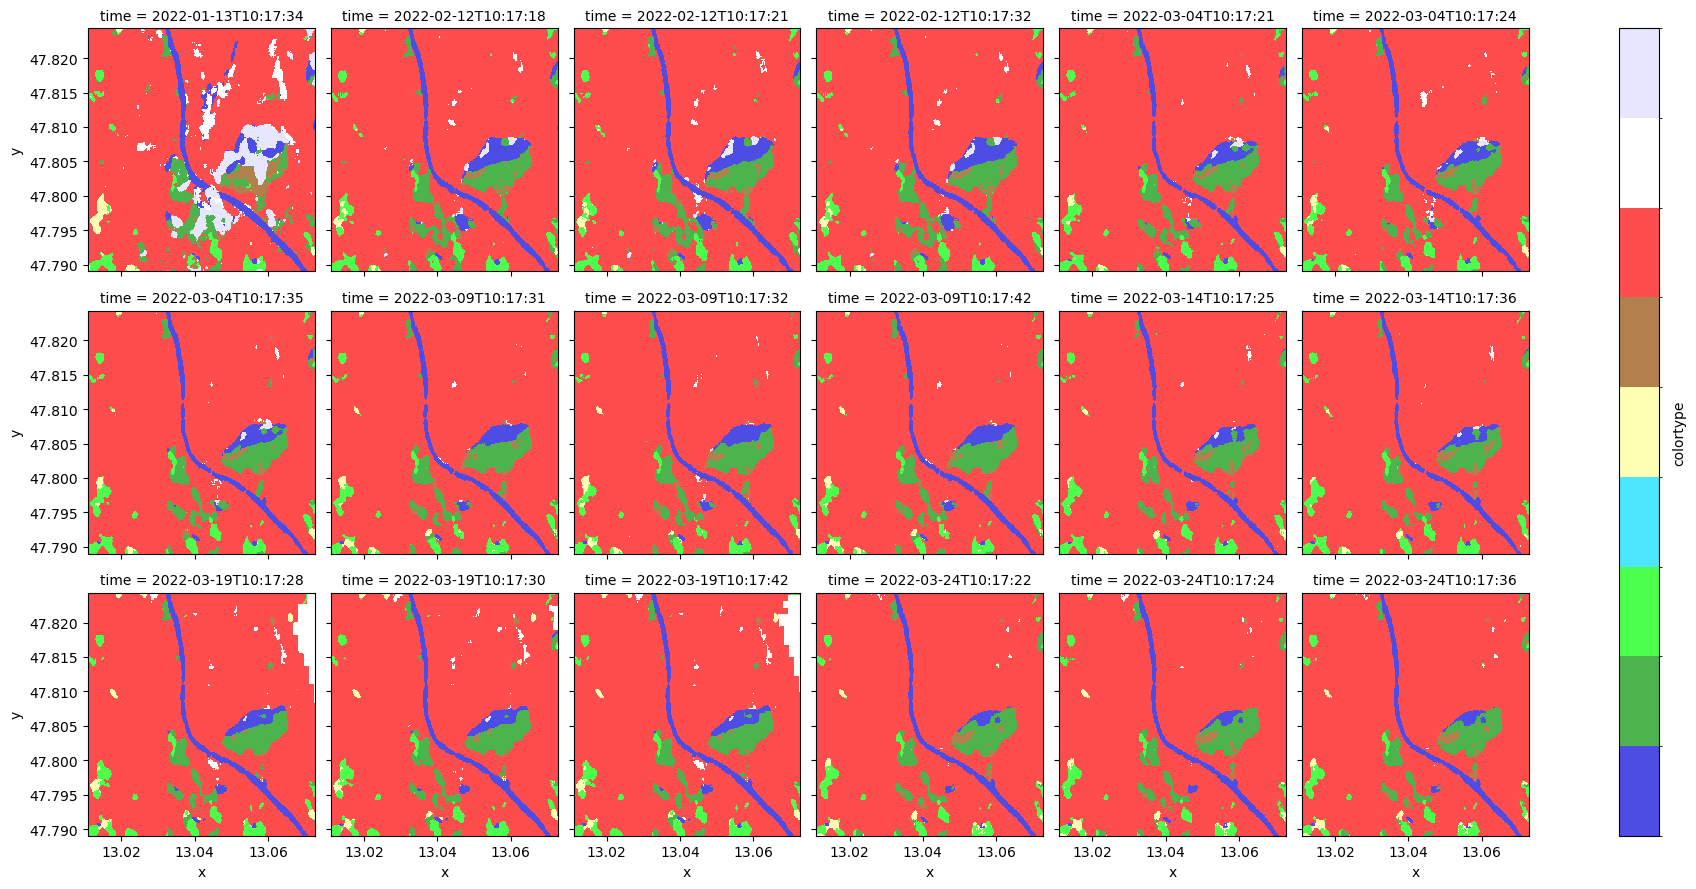

In [9]:
colors = {
    "water": [77, 77, 230],
    "trees": [77, 179, 77],
    "grass": [77, 255, 77],
    "flooded_vegetation": [77, 230, 255],
    "crops": [255, 255, 179],
    "shrub_and_scrub": [179, 128, 77],
    "built": [255, 77, 77],
    "bare": [255, 255, 255],
    "snow_and_ice": [230, 230, 255],
}

values = list(range(0, 9))
levels = [x - 0.5 for x in values + [max(values) + 1]]
colors = list([np.array(x)/255 for x in colors.values()])
legend = {"ticks": [], "label": "colortype"}

data.plot(x = "x", y = "y", col = "time", col_wrap=6, levels = levels, colors = colors, cbar_kwargs = legend);